In [2]:
from helper import *

# Device detection and setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

set_seed = 42

Using device: cuda
CUDA device: NVIDIA GeForce RTX 4060 Ti
CUDA memory: 16.0 GB


In [3]:
# Iris Network
class IrisNet(nn.Module):
    def __init__(self):
        super(IrisNet, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 3)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

In [26]:
# Iris Dataset
iris = sklearn_datasets.load_iris()
X_iris = torch.FloatTensor(iris.data)
y_iris = torch.LongTensor(iris.target)

# Shuffle the dataset before splitting (deterministic with seed)
np.random.seed(42)
indices = np.random.permutation(len(X_iris))
X_iris_shuffled = X_iris[indices]
y_iris_shuffled = y_iris[indices]

# Split into train/test
split = int(0.67 * len(X_iris_shuffled))
X_iris_train, X_iris_test = X_iris_shuffled[:split], X_iris_shuffled[split:]
y_iris_train, y_iris_test = y_iris_shuffled[:split], y_iris_shuffled[split:]

iris_train_loader = DataLoader(TensorDataset(X_iris_train, y_iris_train), batch_size=16, shuffle=False)
iris_test_loader = DataLoader(TensorDataset(X_iris_test, y_iris_test), batch_size=16, shuffle=False)

# Show specific samples:
# show_iris_samples(X_iris_shuffled, y_iris_shuffled, indices=[0, 50, 100])


# Example usage (deterministic training):
iris_model = IrisNet()
iris_criterion = nn.CrossEntropyLoss()
iris_optimizer = optim.Adam(iris_model.parameters(), lr=0.01)
iris_losses, trained_iris = train_model(iris_model, iris_train_loader, iris_criterion, iris_optimizer, num_epochs=50, seed=42, verbose=True)

All seeds set to: 42
Model weights initialized with seed: 42
Training on device: cuda
Epoch [20/50], Loss: 0.119866
Epoch [20/50], Loss: 0.119866
Epoch [40/50], Loss: 0.095862
Epoch [40/50], Loss: 0.095862


In [5]:
# Show Example of dataset
show_iris_samples(X_iris_shuffled, y_iris_shuffled, indices=75)  # Single index

# Make prediction
print()
predictions_iris, probabilities_iris, predicted_classes_iris, sample_targets_iris = predict_and_show(trained_iris, iris_test_loader, dataset_type='iris', indices=5)  # Single index

Iris Dataset Samples:
--------------------------------------------------------------------------------
Index  Class        Sepal_L  Sepal_W  Petal_L  Petal_W 
--------------------------------------------------------------------------------
75     versicolor   5.40     3.00     4.50     1.50    

Iris Predictions:
------------------------------------------------------------
Index  True         Pred         Confidence  
------------------------------------------------------------
5      setosa       setosa       0.9996      


In [6]:
iris_inputs, iris_activations, iris_outputs = get_activations(trained_iris, iris_train_loader, dataset_type='iris')
single_iris_inputs, single_iris_activations, single_iris_outputs = get_activations(trained_iris, iris_test_loader, dataset_type='iris', indices=5)

In [22]:
single_iris_activations.shape

torch.Size([1, 384])

In [23]:
indices_iris, distances_iris = find_knn(iris_activations, single_iris_activations, k=5, metric='l2')
filtered_iris_loader, filtered_size = create_filtered_dataloader(iris_train_loader, exclude_indices=indices_iris, batch_size=64, shuffle=False)

In [25]:
distances_iris

tensor([0.5526, 0.8309, 0.8885, 0.9598, 1.2159])

In [27]:
filter_iris_model = IrisNet()
iris_criterion = nn.CrossEntropyLoss()
iris_optimizer = optim.Adam(filter_iris_model.parameters(), lr=0.01)
iris_losses, filter_trained_iris = train_model(filter_iris_model, filtered_iris_loader, iris_criterion, iris_optimizer, num_epochs=50, seed=42, verbose=True)

All seeds set to: 42
Model weights initialized with seed: 42
Training on device: cuda
Epoch [20/50], Loss: 0.154552
Epoch [40/50], Loss: 0.102662


In [28]:
# Base Model prediction
predictions_base_iris, probabilities_iris, predicted_classes_iris, sample_targets_iris = predict_and_show(trained_iris, iris_test_loader, dataset_type='iris', indices=5)

# Filtered Model prediction
predictions_filter_iris, probabilities_iris, predicted_classes_iris, sample_targets_iris = predict_and_show(filter_trained_iris, iris_test_loader, dataset_type='iris', indices=5)

Iris Predictions:
------------------------------------------------------------
Index  True         Pred         Confidence  
------------------------------------------------------------
5      setosa       setosa       0.9996      
Iris Predictions:
------------------------------------------------------------
Index  True         Pred         Confidence  
------------------------------------------------------------
5      setosa       setosa       0.9986      


In [11]:
print(nn.CrossEntropyLoss()(predictions_base_iris, sample_targets_iris))
print(nn.CrossEntropyLoss()(predictions_filter_iris, sample_targets_iris))

tensor(0.0004)
tensor(0.0013)


In [12]:
# Function to calculate CrossEntropy loss for different k and indices
def calculate_cross_entropy_for_k_and_indices(model, train_loader, test_loader, list_of_k, list_of_indices):
    cross_results = {
        'closest_cross_entropy': {},
        'last_cross_entropy': {},
        'random_cross_entropy': {}
    }

    for k in list_of_k:
        cross_results['closest_cross_entropy'][k] = []
        cross_results['last_cross_entropy'][k] = []
        cross_results['random_cross_entropy'][k] = []

        for index in list_of_indices:

            # Get activations for the single sample
            single_inputs, single_activations, _ = get_activations(model, test_loader, dataset_type='iris', indices=index)

            # Find k-nearest neighbors for the entire dataset
            indices_knn, _ = find_knn(iris_activations, single_activations, k=len(iris_activations), metric='cosine')

            # Closest k neighbors
            closest_indices = indices_knn[:k]
            # Last in the list
            last_indices = indices_knn[-k:]
            # Random indices
            random_indices = np.random.choice(indices_knn, k, replace=False)

            for subset_name, subset_indices in zip(['closest_cross_entropy', 'last_cross_entropy', 'random_cross_entropy'], [closest_indices, last_indices, random_indices]):

                # Create filtered dataloader
                filtered_loader, _ = create_filtered_dataloader(train_loader, exclude_indices=subset_indices, batch_size=64, shuffle=False)

                # Train a new model completely with the filtered dataset
                filtered_model = IrisNet()
                optimizer_tmp = optim.Adam(filtered_model.parameters(), lr=0.01)
                criterion = nn.CrossEntropyLoss()
                train_model(filtered_model, filtered_loader, criterion, optimizer_tmp, num_epochs=50, seed=42, verbose=False, continue_training=False)

                # Predict and calculate CrossEntropy loss
                predictions, _, _, targets = predict_and_show(filtered_model, test_loader, dataset_type='iris', indices=index)
                cross_loss = nn.CrossEntropyLoss()(predictions, targets).item()
                cross_results[subset_name][k].append(cross_loss)

    return cross_results

In [33]:
list_of_k = list(range(1, 30, 5))
#list_of_k = [1, 5, 10, 50, 100, 250]

list_of_indices = [0,1,2,3,4,5,6,7,8,9]

In [34]:
cross_results = calculate_cross_entropy_for_k_and_indices(trained_iris, iris_train_loader, iris_test_loader, list_of_k, list_of_indices)

All seeds set to: 42
Model weights initialized with seed: 42
Iris Predictions:
------------------------------------------------------------
Index  True         Pred         Confidence  
------------------------------------------------------------
0      setosa       setosa       0.9975      
All seeds set to: 42
Model weights initialized with seed: 42
Iris Predictions:
------------------------------------------------------------
Index  True         Pred         Confidence  
------------------------------------------------------------
0      setosa       setosa       0.9980      
All seeds set to: 42
Model weights initialized with seed: 42
Iris Predictions:
------------------------------------------------------------
Index  True         Pred         Confidence  
------------------------------------------------------------
0      setosa       setosa       0.9980      
All seeds set to: 42
Model weights initialized with seed: 42
Iris Predictions:
------------------------------------------

Iris Predictions:
------------------------------------------------------------
Index  True         Pred         Confidence  
------------------------------------------------------------
5      setosa       setosa       0.9996      


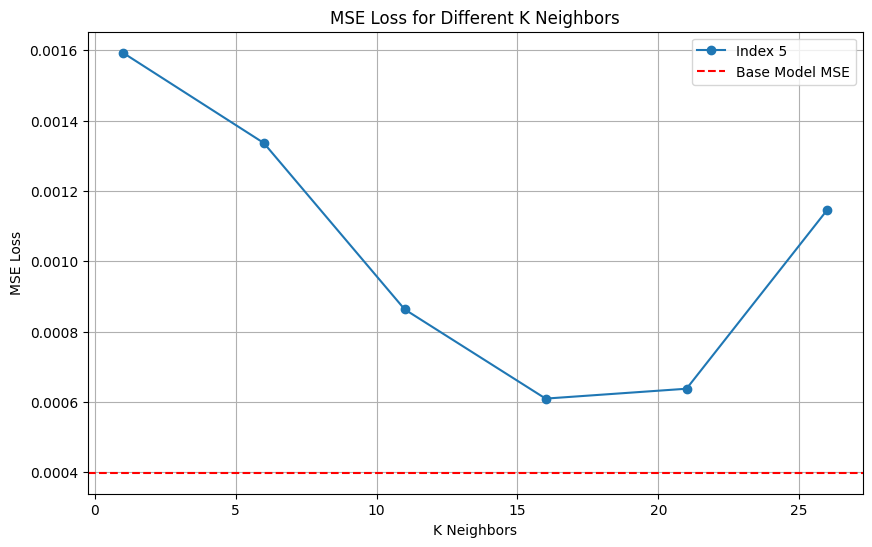

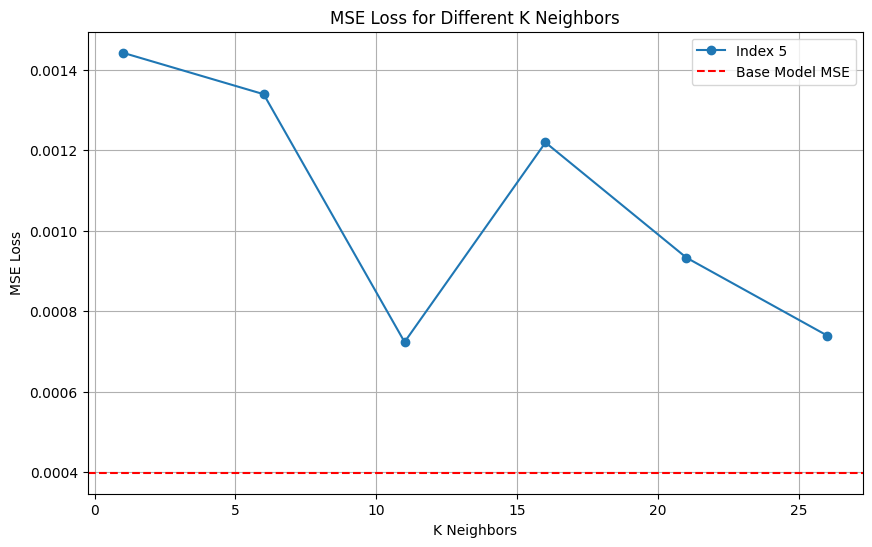

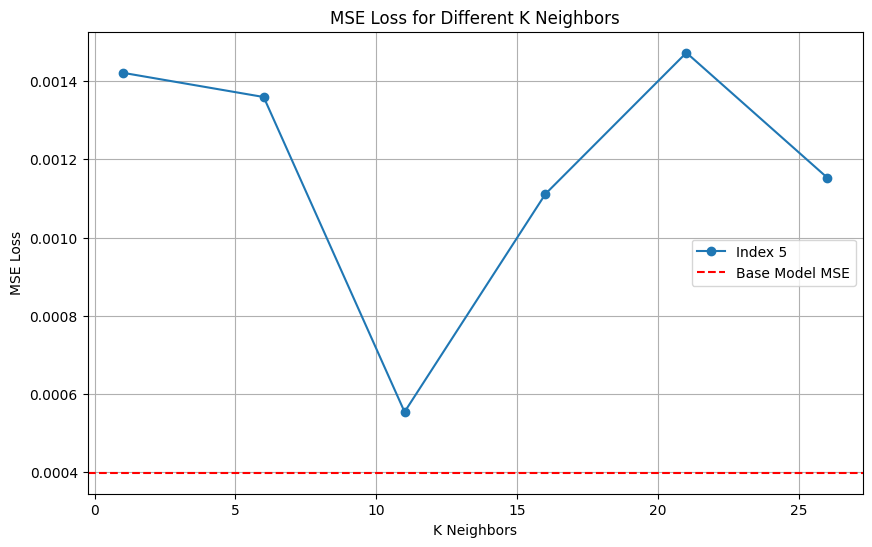

In [40]:
index_base = 5

predictions_base_iris, probabilities_iris, predicted_classes_iris, sample_targets_iris = predict_and_show(trained_iris, iris_test_loader, dataset_type='iris', indices=index_base)
base_error = nn.CrossEntropyLoss()(predictions_base_iris, sample_targets_iris)

visualize_mse_results(cross_results['closest_cross_entropy'], list_of_indices, selected_index=index_base, base_mse=base_error)  # Visualize for a specific index
visualize_mse_results(cross_results['last_cross_entropy'], list_of_indices, selected_index=index_base, base_mse=base_error)  # Visualize for a specific index
visualize_mse_results(cross_results['random_cross_entropy'], list_of_indices, selected_index=index_base, base_mse=base_error)  # Visualize for a specific index

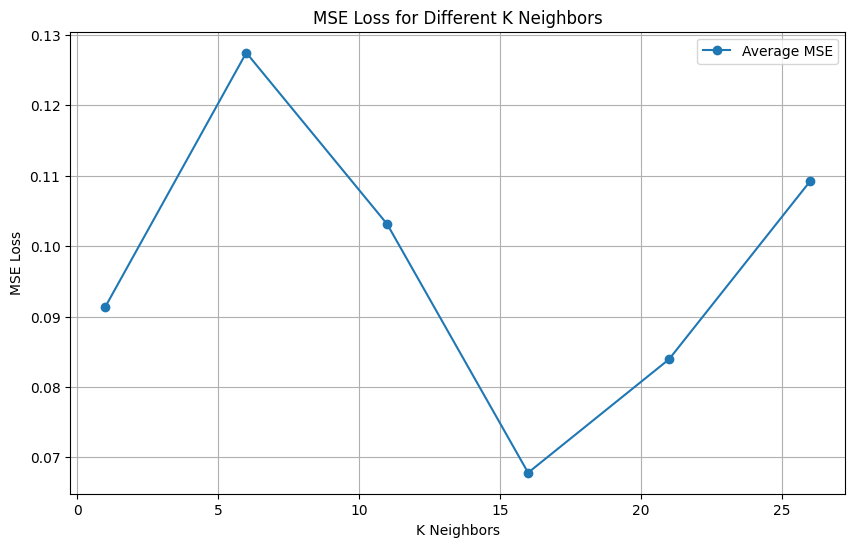

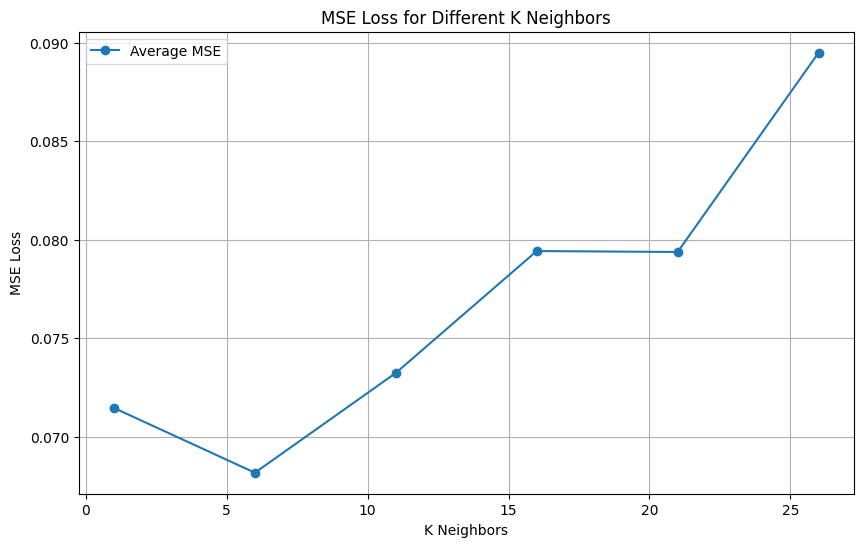

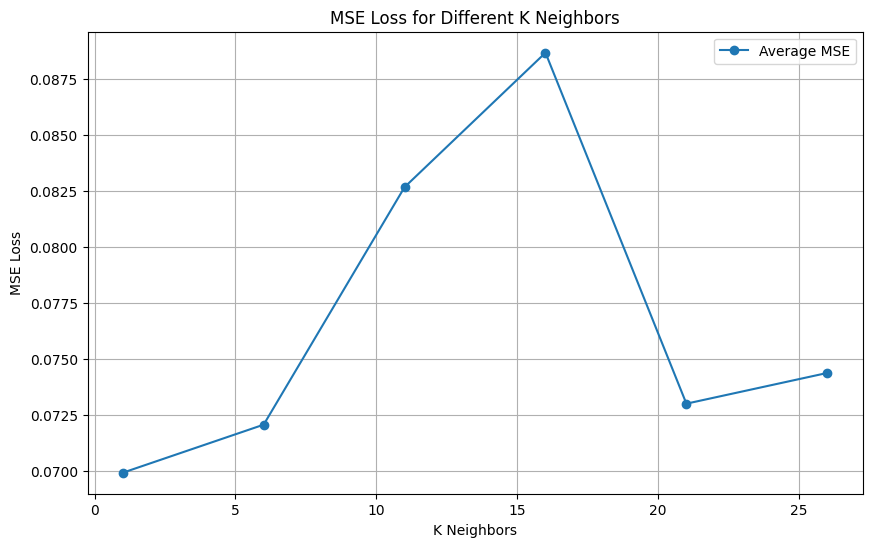

In [41]:
visualize_mse_results(cross_results['closest_cross_entropy'], list_of_indices, average=True)  # Visualize averaged results
visualize_mse_results(cross_results['last_cross_entropy'], list_of_indices, average=True)  # Visualize averaged results
visualize_mse_results(cross_results['random_cross_entropy'], list_of_indices, average=True)  # Visualize averaged results

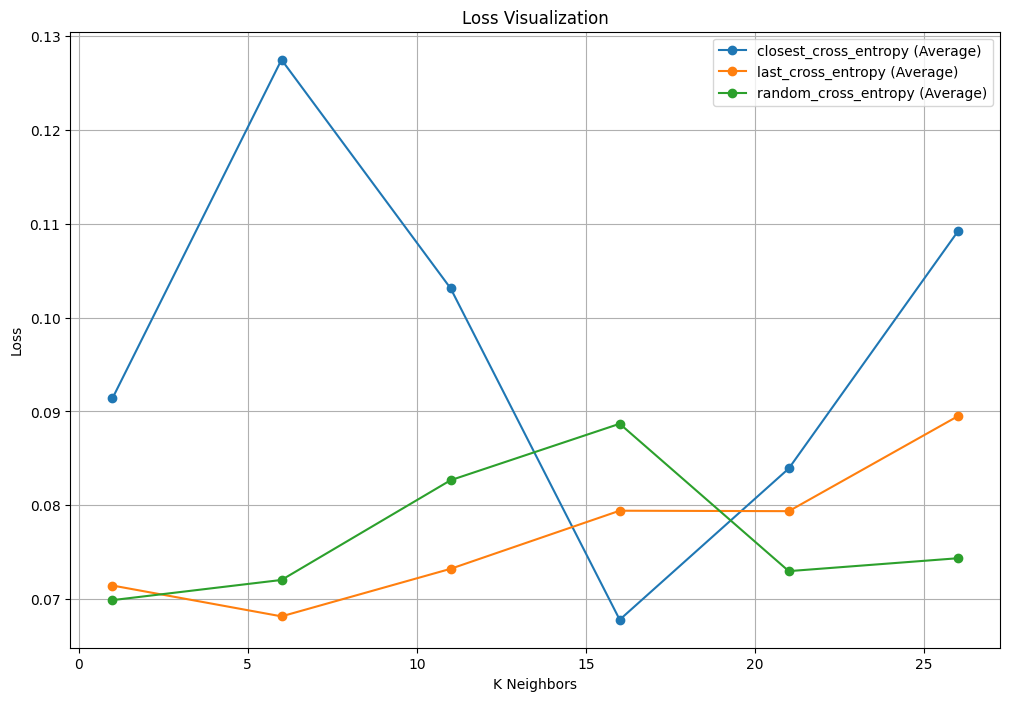

In [36]:
visualize_results(cross_results, list_of_indices, average=True)

In [18]:
# Updated Visualization function
def visualize_results(mse_results, list_of_indices, selected_index=None, average=False, base_mse=None, normalize=False, title="Loss Visualization", ylabel="Loss"):
    import matplotlib.pyplot as plt
    import numpy as np

    plt.figure(figsize=(12, 8))

    if average:
        # Prepare data for averages
        averages = {}
        for key, results in mse_results.items():
            averages[key] = [np.mean(results[k]) for k in results.keys()]

        # Normalize if required
        if normalize:
            max_value = max([max(values) for values in averages.values()])
            averages = {key: [val / max_value for val in values] for key, values in averages.items()}

        # Plot averages side by side
        for key, values in averages.items():
            plt.plot(list(mse_results[key].keys()), values, label=f"{key} (Average)", marker="o")

    elif selected_index is not None:
        # Plot for a specific index
        for key, results in mse_results.items():
            plt.plot(list(results.keys()), [results[k][selected_index] for k in results.keys()], label=f"{key} (Index {selected_index})", marker="o")

    else:
        # Plot all indices
        for key, results in mse_results.items():
            for idx, values in enumerate(zip(*results.values())):
                plt.plot(list(results.keys()), values, label=f"{key} (Index {idx})", marker="o")

    if base_mse is not None:
        plt.axhline(y=base_mse, color="r", linestyle="--", label="Base MSE")

    plt.xlabel("K Neighbors")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()